In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import os
import cv2

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, Conv2DTranspose, Input
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.preprocessing import image
from PIL import Image 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler 
import pandas as pd
import os #
from google.colab import drive
import time, random
import seaborn as sns
sns.set_style('darkgrid')

In [5]:
drive.mount('/content/drive/') # монтируем google диск

Mounted at /content/drive/


In [7]:
path = '/content/data'

# unzip files first to working directory
# We could use also unzipped data source, but why not to learn something new?
with zipfile.ZipFile('/content/drive/MyDrive/uii/train.zip', 'r') as zip_ref:
    zip_ref.extractall(path)

with zipfile.ZipFile( '/content/drive/MyDrive/uii/test.zip', 'r') as zip_ref:
    zip_ref.extractall(path)  
    
with zipfile.ZipFile( '/content/drive/MyDrive/uii/train_cleaned.zip', 'r') as zip_ref:
    zip_ref.extractall(path)  
    
with zipfile.ZipFile( '/content/drive/MyDrive/uii/sampleSubmission_csv.zip', 'r') as zip_ref:
    zip_ref.extractall(path)  

In [8]:
train_img = sorted(os.listdir(path + '/train'))
train_cleaned_img = sorted(os.listdir(path + '/train_cleaned'))
test_img = sorted(os.listdir(path + '/test'))

In [9]:
def process_image(path):
    img = cv2.imread(path)
    img = np.asarray(img, dtype="float32")
    img = cv2.resize(img, (540, 420))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (420, 540, 1))
    
    return img

In [12]:
train = []
train_cleaned = []
test = []

for f in sorted(os.listdir(path + '/train/')):
    train.append(process_image(path + '/train/' + f))

for f in sorted(os.listdir(path + '/train_cleaned/')):
    train_cleaned.append(process_image(path + '/train_cleaned/' + f))
   
for f in sorted(os.listdir(path + '/test/')):
    test.append(process_image(path + '/test/' + f))

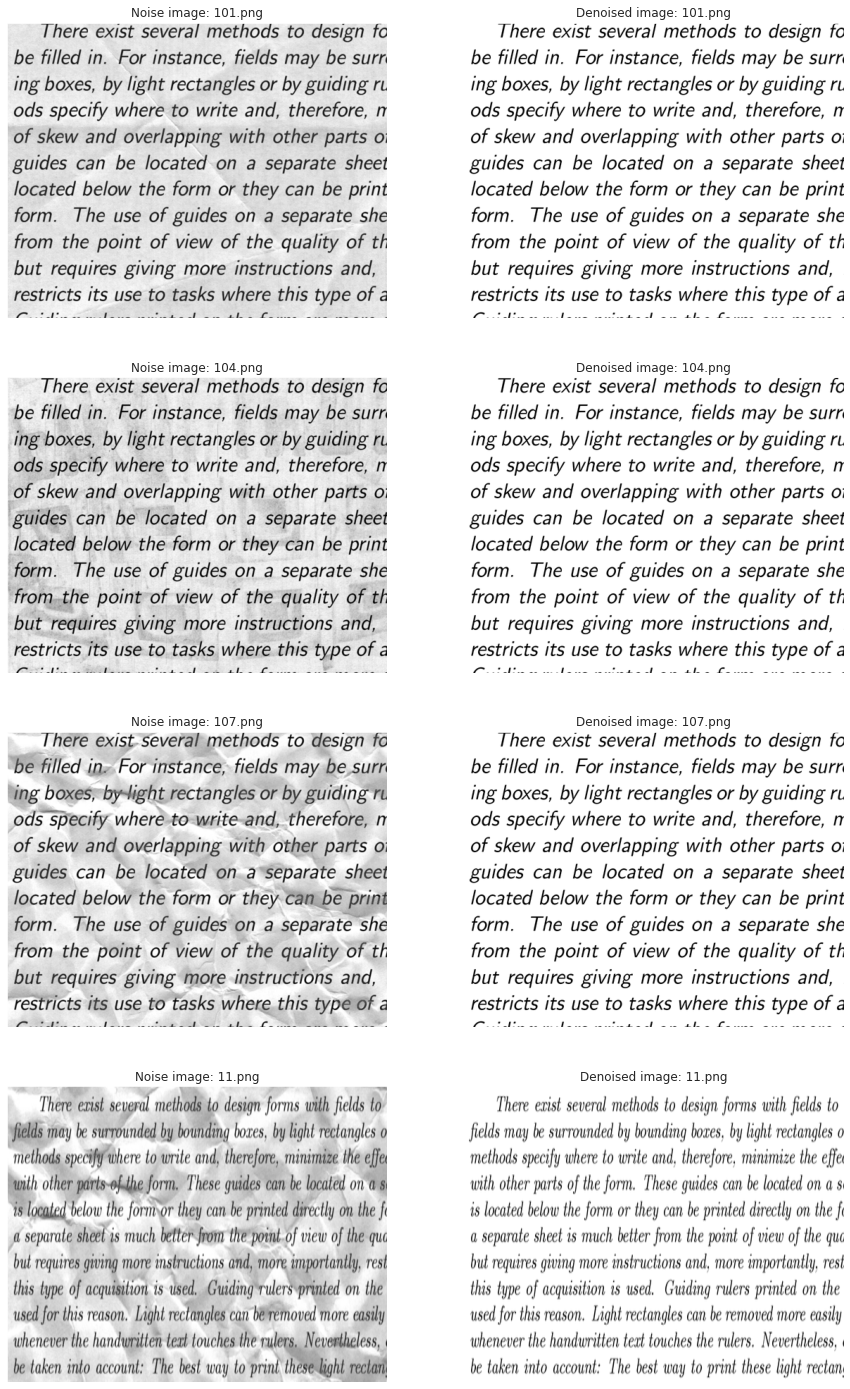

In [13]:
plt.figure(figsize=(15,25))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train[i][:,:,0], cmap='gray')
    plt.title('Noise image: {}'.format(train_img[i]))
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_cleaned[i][:,:,0], cmap='gray')
    plt.title('Denoised image: {}'.format(train_img[i]))

plt.show()

In [14]:
X_train = np.asarray(train)
y_train = np.asarray(train_cleaned)
X_test = np.asarray(test)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15)

In [15]:
conv_autoencoder = Sequential()

# Encoder
conv_autoencoder.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(420,540,1), activation='relu', padding='same'))
conv_autoencoder.add(MaxPooling2D((2, 2), padding='same'))

conv_autoencoder.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same'))
conv_autoencoder.add(MaxPooling2D((2, 2), padding='same'))



# Decoder
conv_autoencoder.add(Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'))
conv_autoencoder.add(Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'))


# Output
conv_autoencoder.add(Conv2D(filters=1, kernel_size=(3,3), activation='sigmoid', padding='same'))

conv_autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 420, 540, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 210, 270, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 210, 270, 16)      4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 105, 135, 16)     0         
 2D)                                                             
                                                                 
 conv2d_transpose (Conv2DTra  (None, 210, 270, 8)      1160      
 nspose)                                                         
                                                        

In [16]:
conv_autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
history= conv_autoencoder.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=200, batch_size=16, callbacks= [early_stop])

Epoch 1/200
8/8 [==============================] - 15s 325ms/step - loss: 0.2065 - mae: 0.4409 - val_loss: 0.1852 - val_mae: 0.4178
Epoch 2/200
8/8 [==============================] - 1s 142ms/step - loss: 0.1543 - mae: 0.3780 - val_loss: 0.1069 - val_mae: 0.3029
Epoch 3/200
8/8 [==============================] - 1s 140ms/step - loss: 0.0815 - mae: 0.2290 - val_loss: 0.0759 - val_mae: 0.1557
Epoch 4/200
8/8 [==============================] - 1s 140ms/step - loss: 0.0723 - mae: 0.1327 - val_loss: 0.0814 - val_mae: 0.1268
Epoch 5/200
8/8 [==============================] - 1s 141ms/step - loss: 0.0748 - mae: 0.1203 - val_loss: 0.0810 - val_mae: 0.1275
Epoch 6/200
8/8 [==============================] - 1s 142ms/step - loss: 0.0729 - mae: 0.1265 - val_loss: 0.0766 - val_mae: 0.1428
Epoch 7/200
8/8 [==============================] - 1s 140ms/step - loss: 0.0685 - mae: 0.1535 - val_loss: 0.0724 - val_mae: 0.1843
Epoch 8/200
8/8 [==============================] - 1s 141ms/step - loss: 0.0674 - 

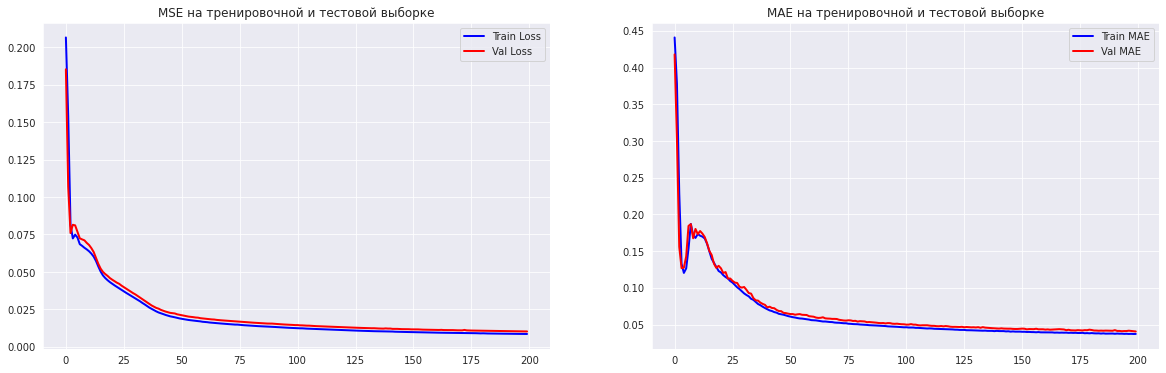

In [18]:
epoch_loss = history.history['loss']
epoch_val_loss = history.history['val_loss']
epoch_mae = history.history['mae']
epoch_val_mae = history.history['val_mae']

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('MSE на тренировочной и тестовой выборке')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mae)), epoch_mae, 'b-', linewidth=2, label='Train MAE')
plt.plot(range(0,len(epoch_val_mae)), epoch_val_mae, 'r-', linewidth=2,label='Val MAE')
plt.title('MAE на тренировочной и тестовой выборке')
plt.legend(loc='best')

plt.show()

In [19]:
y_pred = conv_autoencoder.predict(X_test, batch_size=16)

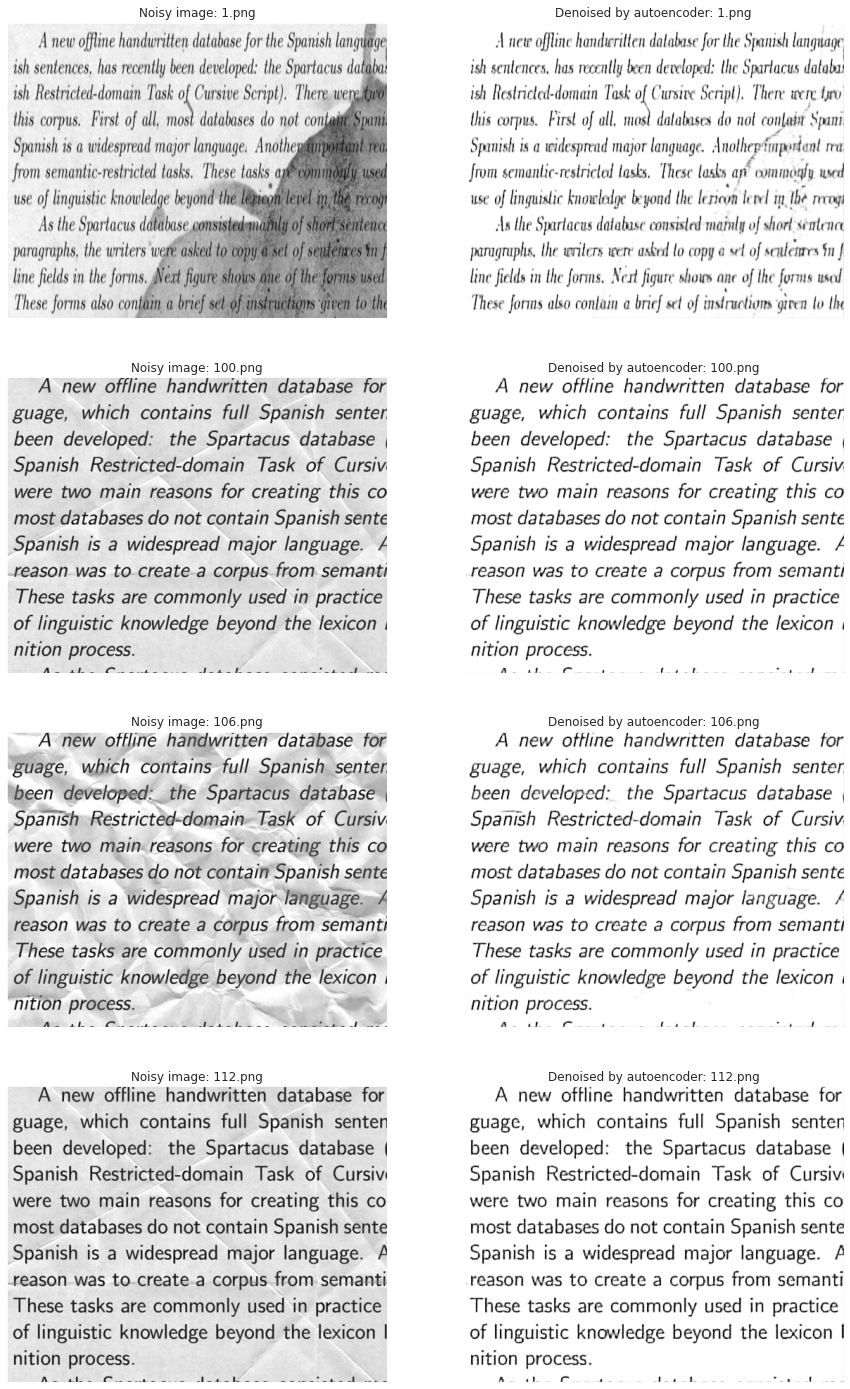

In [20]:
plt.figure(figsize=(15,25))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[i][:,:,0], cmap='gray')
    plt.title('Noisy image: {}'.format(test_img[i]))
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(y_pred[i][:,:,0], cmap='gray')
    plt.title('Denoised by autoencoder: {}'.format(test_img[i]))

plt.show()